In [ ]:
# Instal required libraries
%pip install numpy_financial
%pip install pyomo
%pip install -q condacolab
%pip install docplex
import condacolab
condacolab.install()
# This step might fail or crash the first time you run it. This is fine. 
# Just run the cell again and it will work.
!conda install -c conda-forge glpk


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os
import math
from docplex.mp.model import Model
from tqdm import tqdm

In [ ]:
# Connect to the Google Drive so you can read the data
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the folder containing the current script
os.chdir("/content/drive/MyDrive/HPP_EMS_Assignment")



### 1. Bidding strategy comparison

Solving the data-driven EMS requires the academic version of cplex, which you might not have. I have already run all the EMS on behalf of you and the inputs are in "./Inputs/", while the outputs are in "./Outputs/day_3/". This part read the bidding strategy from the three EMSs and compared the bidding strategies. You can choose the start date and end date from 2030-01-07 to 2030-12-31. 
- Play with different dates and what do you find? 

In [3]:

start_date_plot = datetime(2030,1,7)
end_date_plot = datetime(2031,1,1)
date_range_15min = pd.date_range(start_date_plot,end_date_plot,freq='15min')
date_range_1h = pd.date_range(start_date_plot,end_date_plot,freq='1h')

# DEMS
output_DEMS_schedule_ts_filename = './Outputs/day_3/DEMS/schedule.csv'
DEMS_schedule = pd.read_csv(output_DEMS_schedule_ts_filename).iloc[:-96,:]
DEMS_schedule.index = date_range_15min[:-1]
P_bid_DEMS = DEMS_schedule['SM']

# SEMS
output_SEMS_schedule_ts_filename = './Outputs/day_3/SEMS/schedule.csv'
SEMS_schedule = pd.read_csv(output_SEMS_schedule_ts_filename)
SEMS_schedule.index = date_range_15min[:-1]
P_bid_SEMS = SEMS_schedule['SM']


# DDEMS
output_DDEMS_schedule_ts_filename = './Outputs/day_3/DDEMS/schedule.csv'
DDEMS_schedule = pd.read_csv(output_DDEMS_schedule_ts_filename)
DDEMS_schedule.index = date_range_15min[:-1]
P_bid_DDEMS = DDEMS_schedule['SM']


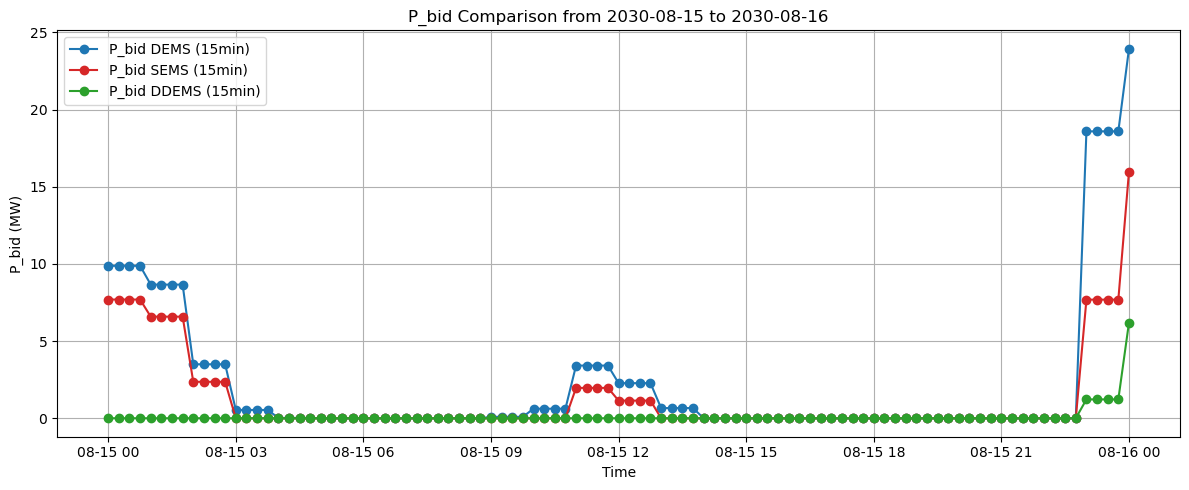

In [4]:
start_date = '2030-08-15'
end_date = '2030-08-16'


date_range_15min_mask = (P_bid_DEMS.index >= start_date) & (P_bid_DEMS.index <= end_date)




P_bid_DEMS_day = P_bid_DEMS[date_range_15min_mask]
P_bid_SEMS_day = P_bid_SEMS[date_range_15min_mask]
P_bid_DDEMS_day = P_bid_DDEMS[date_range_15min_mask]

plt.figure(figsize=(12, 5))

plt.plot(P_bid_DEMS_day, label='P_bid DEMS (15min)', color='tab:blue', marker='o')
plt.plot(P_bid_SEMS_day, label='P_bid SEMS (15min)', color='tab:red', marker='o')
plt.plot(P_bid_DDEMS_day, label='P_bid DDEMS (15min)', color='tab:green', marker='o')

plt.title(f'P_bid Comparison from {start_date} to {end_date}')
plt.xlabel('Time')
plt.ylabel('P_bid (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Compare imbalance revenues based on dual-price and single-price settlement

This part compares the imbalance revenues based on dual-price and single price. Run the following code and anwser the following question:
- Which settlement causes lower revenue?
- Can you explain the reason?

In [7]:
def RTSim(P_HPP_SM_opt, EMS_type):  

    Wind_data = pd.read_csv('./Inputs/Wind.csv')
    if EMS_type =="DEMS":
        Degradation = pd.read_csv('./Outputs/day_3/DEMS/Degradation.csv')['nld']
    elif EMS_type == "SEMS":
        Degradation = pd.read_csv('./Outputs/day_3/SEMS/Degradation.csv')['nld']
    else:
        Degradation = pd.read_csv('./Outputs/day_3/DDEMS/Degradation.csv')['nld']

    Wind_measurement = Wind_data['Measurement']*120
    

    eta_cha = 0.98
    eta_dis = 0.97
    E0 = 30
    Emin = 6

    PbMax = 20
    EBESS = 60
    P_grid_limit = 120
    
    E = E0

    P_HPP_RT_ts = []
    for i in tqdm(range(len(P_HPP_SM_opt))):
 
        P_ref = P_HPP_SM_opt.iloc[i]       # Target HPP output
        P_wind = Wind_measurement.iloc[i]  # Measured wind
        degradation = Degradation.iloc[int(i/96)]  # Daily degradation (assuming 96 steps/day)
        
        # Battery available capacity
        E_b = EBESS * (1 - degradation)
        Emax = E_b * 0.9


        if P_wind >= P_ref:
            # Excess wind → follow reference + charge battery
            p_surplus = P_wind - P_ref
            if E < Emax:
                p_cha = min(p_surplus, PbMax, (Emax - E) / (0.25 * eta_cha))
                
                E += p_cha * 0.25 * eta_cha
                P_HPP_RT_t = P_ref
                
            else:
                # Battery full → curtail
                P_HPP_RT_t = P_ref

        else:
            # Wind not enough → discharge battery to meet reference
            p_deficit = P_ref - P_wind
            if E > Emin:
                p_dis = min(p_deficit / eta_dis, PbMax, (E - Emin) / 0.25 * eta_dis)

                E -= p_dis * 0.25 / eta_dis
                P_HPP_RT_t = P_wind + p_dis * eta_dis
            else:
                # Battery empty → cannot fully meet reference
                P_HPP_RT_t = P_wind

            # Enforce grid limit
        P_HPP_RT_t = min(P_HPP_RT_t, P_grid_limit)


        P_HPP_RT_ts.append(P_HPP_RT_t)


    P_HPP_RT_ts = pd.Series(P_HPP_RT_ts)        
    return P_HPP_RT_ts


def profit_calculation(P_HPP_SM_opt, P_HPP_RT_ts, SP_cleared, RP_cleared, BP_up_cleared, BP_dw_cleared, settlement):
    
    P_HPP_SM_opt = P_HPP_SM_opt.reset_index(drop=True)
    RP_cleared = RP_cleared.reset_index(drop=True)
    BP_up_cleared = BP_up_cleared.reset_index(drop=True)
    BP_dw_cleared = BP_dw_cleared.reset_index(drop=True)

    RP_cleared = RP_cleared.iloc[:-24]
    BP_up_cleared = BP_up_cleared.iloc[:-24]
    BP_dw_cleared = BP_dw_cleared.iloc[:-24]


    RP_cleared_15min = RP_cleared.repeat(4).reset_index(drop=True)
    BP_dw_cleared_15min = BP_dw_cleared.repeat(4).reset_index(drop=True)
    BP_up_cleared_15min = BP_up_cleared.repeat(4).reset_index(drop=True)


    P_imbalance_ts = P_HPP_RT_ts - P_HPP_SM_opt
    P_pos_imbalance_ts = P_imbalance_ts.clip(lower=0)
    P_neg_imbalance_ts = -P_imbalance_ts.clip(upper=0)

    if settlement == 'dual':
        im_revenue = BP_dw_cleared_15min * P_pos_imbalance_ts*0.25 - BP_up_cleared_15min * P_neg_imbalance_ts*0.25
        im_cost = 0
    else:
        im_revenue = RP_cleared_15min * P_imbalance_ts *0.25
        im_cost = 0.13 * abs(P_imbalance_ts)*0.25        




    return im_revenue, im_cost



P_HPP_DDEMS_RT_ts = RTSim(P_bid_DDEMS,'DDEMS')

Market_data = pd.read_csv('./Inputs/Market.csv')


SP_cleared = Market_data['SM_cleared']
RP_cleared = Market_data['reg_cleared']
BP_up_cleared = Market_data['BM_Up_cleared']
BP_dw_cleared = Market_data['BM_Down_cleared']

# Dual
im_revenue_dual, im_cost_dual = profit_calculation(P_bid_DDEMS, P_HPP_DDEMS_RT_ts, SP_cleared, RP_cleared, BP_up_cleared, BP_dw_cleared, settlement='dual')
# Single
im_revenue_single, im_cost_single = profit_calculation(P_bid_DDEMS, P_HPP_DDEMS_RT_ts, SP_cleared, RP_cleared, BP_up_cleared, BP_dw_cleared, settlement='single')

print(f"Imbalance revenue with dual-price settlement: {(im_revenue_dual-im_cost_dual).sum():.0f}")
print(f"Imbalance revenue with single-price settlement: {(im_revenue_single-im_cost_single).sum():.0f}")

100%|██████████| 34464/34464 [00:00<00:00, 183311.28it/s]

Imbalance revenue with dual-price settlement: -1591009
Imbalance revenue with single-price settlement: -1479936


### 3. Profits comparison

This part compares the profits of the HPP with 3 EMSs. Run the code and get the figure, each scatter in the plot showing the daily profits of the relevant EMSs. Anwser the following question:
- Which EMS has the highest annual profits?
- Does the EMS with highest annual profits always better than the others every day? Why?


In [8]:
# DEMS
output_DEMS_revenue_ts_filename = './Outputs/day_3/DEMS/revenue.csv'
DEMS_revenue = pd.read_csv(output_DEMS_revenue_ts_filename).iloc[:-4,:]

revenue_DEMS = DEMS_revenue['SM_revenue'] + DEMS_revenue['im_revenue'] - DEMS_revenue['Deg_cost_by_cycle']

# SEMS
output_SEMS_revenue_ts_filename = './Outputs/day_3/SEMS/revenue.csv'
SEMS_revenue = pd.read_csv(output_SEMS_revenue_ts_filename).iloc[:-1,:]

revenue_SEMS = SEMS_revenue['SM_revenue'] + SEMS_revenue['im_revenue'] - SEMS_revenue['Deg_cost_by_cycle']


# DDEMS
output_DDEMS_revenue_ts_filename = './Outputs/day_3/DDEMS/revenue.csv'
DDEMS_revenue = pd.read_csv(output_DDEMS_revenue_ts_filename)

revenue_DDEMS = DDEMS_revenue['SM_revenue'] + DDEMS_revenue['im_revenue'] - DDEMS_revenue['Deg_cost_by_cycle']





Annual Profits Summary:
DEMS   Profits: €12388606
SEMS   Profits: €12616773
DDEMS  Profits: €13017925


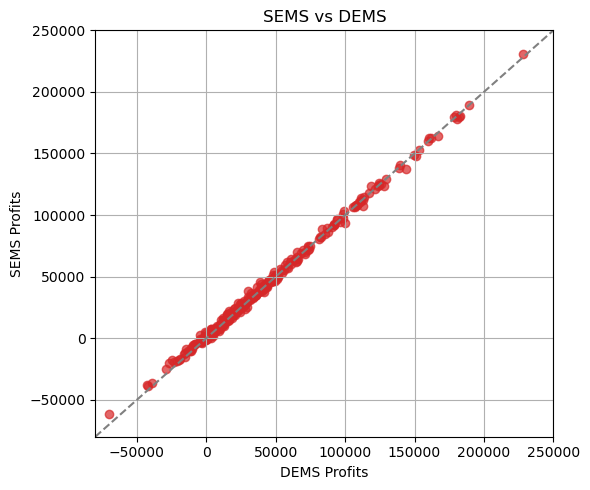

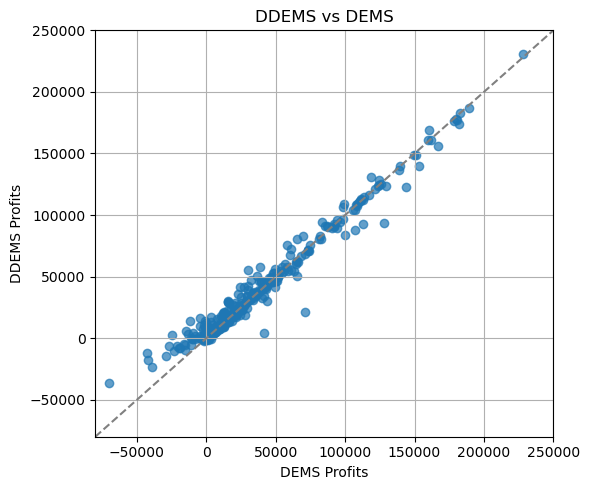

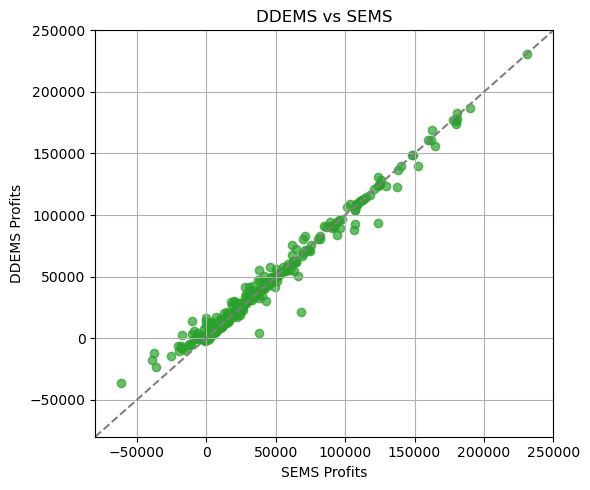

In [9]:
annual_profit_DEMS = revenue_DEMS.sum()
annual_profit_SEMS = revenue_SEMS.sum()
annual_profit_DDEMS = revenue_DDEMS.sum()


print("Annual Profits Summary:")
print(f"DEMS   Profits: €{annual_profit_DEMS:.0f}")
print(f"SEMS   Profits: €{annual_profit_SEMS:.0f}")
print(f"DDEMS  Profits: €{annual_profit_DDEMS:.0f}")

x_min = -80000
x_max = 250000
plt.figure(figsize=(6, 5))
plt.scatter(revenue_DEMS, revenue_SEMS, alpha=0.7, color='tab:red')
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', label='y = x') 
plt.xlabel('DEMS Profits')
plt.ylabel('SEMS Profits')
plt.title('SEMS vs DEMS')
plt.xlim([x_min,x_max])
plt.ylim([x_min,x_max])
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(revenue_DEMS, revenue_DDEMS, alpha=0.7, color='tab:blue')
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', label='y = x') 
plt.xlabel('DEMS Profits')
plt.ylabel('DDEMS Profits')
plt.title('DDEMS vs DEMS')
plt.xlim([x_min,x_max])
plt.ylim([x_min,x_max])
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(revenue_SEMS, revenue_DDEMS, alpha=0.7, color='tab:green')
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', label='y = x') 
plt.xlabel('SEMS Profits')
plt.ylabel('DDEMS Profits')
plt.title('DDEMS vs SEMS')
plt.xlim([x_min,x_max])
plt.ylim([x_min,x_max])
plt.grid(True)
plt.tight_layout()
plt.show()